✅ Loaded matrix: 36753 genes x 800 cells


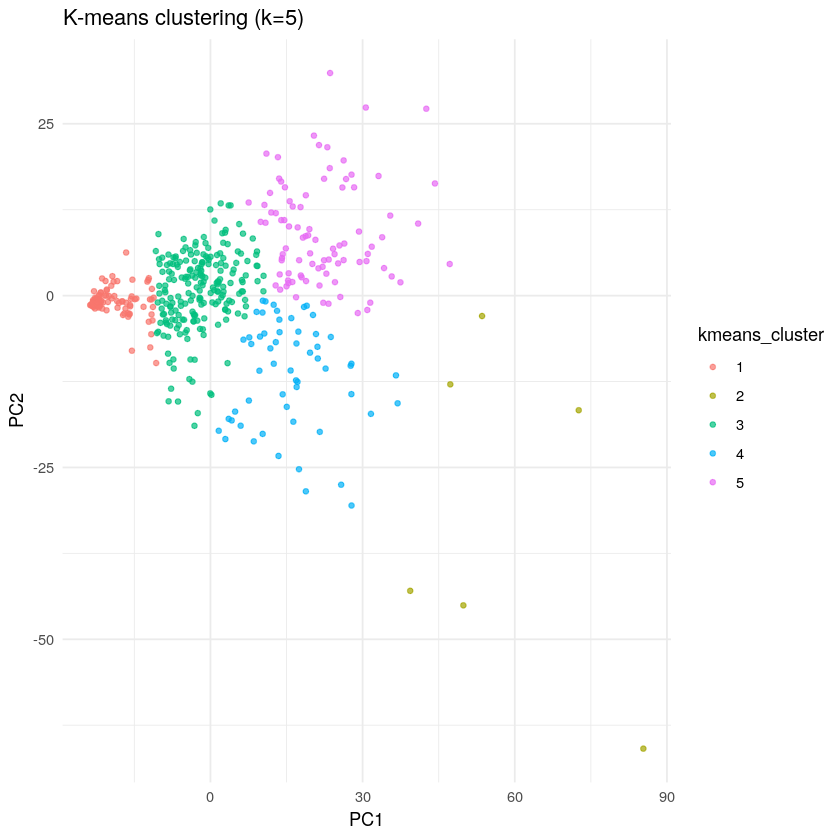

✅ Output salvati in:  /home/jovyan/work/Results/script1 


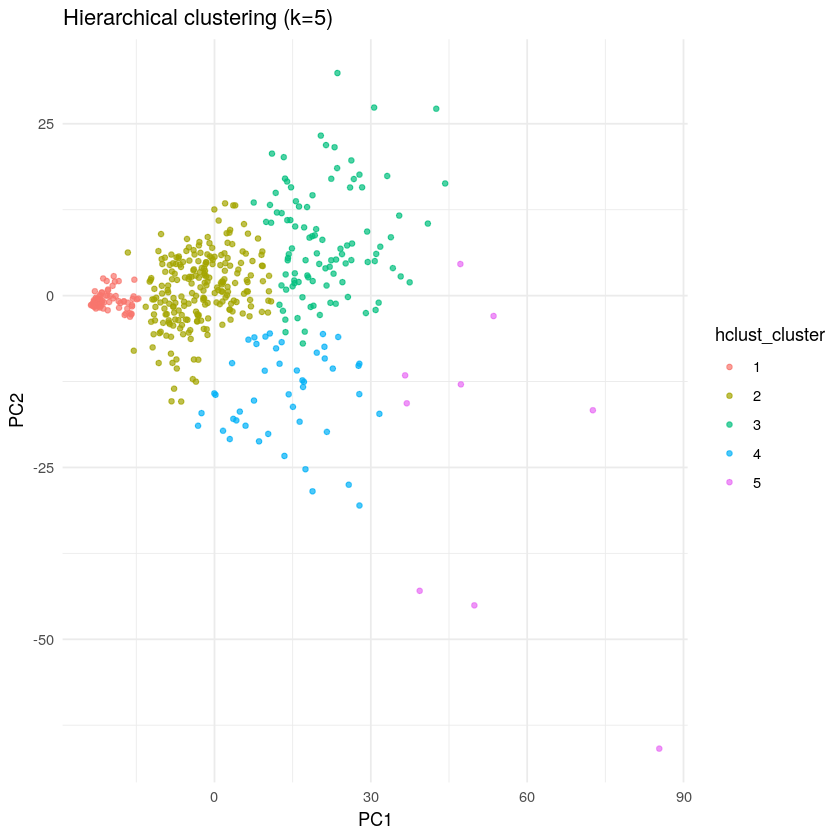

In [1]:
# ================== SCRIPT 1 — PCA + Clustering ==================
suppressPackageStartupMessages({
  library(Matrix)
  library(stats)
  library(ggplot2)
})

# ---------- PATHS ----------
base_dir    <- "/home/jovyan/work"
data_dir    <- file.path(base_dir, "Data")
results_dir <- file.path(base_dir, "Results", "script1")
dir.create(results_dir, showWarnings = FALSE, recursive = TRUE)

matrix_file   <- file.path(data_dir, "matrix.mtx.gz")
features_file <- file.path(data_dir, "features.tsv.gz")  # 10x: col1=gene_id
barcodes_file <- file.path(data_dir, "barcodes.tsv.gz")  # 10x: col1=barcode

# ---------- LOAD 10X ----------
mat <- readMM(matrix_file)

# prendi SOLO la prima colonna (ID) da features/barcodes
genes_df    <- read.delim(features_file, header = FALSE, stringsAsFactors = FALSE)
barcodes_df <- read.delim(barcodes_file, header = FALSE, stringsAsFactors = FALSE)

genes    <- genes_df[[1]]
barcodes <- barcodes_df[[1]]

stopifnot(nrow(mat) == length(genes))
stopifnot(ncol(mat) == length(barcodes))

rownames(mat) <- genes
colnames(mat) <- barcodes

cat(sprintf("✅ Loaded matrix: %d genes x %d cells\n", nrow(mat), ncol(mat)))

# ---------- SUBSAMPLE (500 cells) ----------
set.seed(42)
if (ncol(mat) > 500) {
  selected_cells <- sample(colnames(mat), 500)
  mat_sub <- mat[, selected_cells, drop = FALSE]
} else {
  mat_sub <- mat
}

# ---------- TOP 1000 VARIABLE GENES ----------
gene_vars   <- apply(mat_sub, 1, var)
top_n       <- min(1000, length(gene_vars))
top_genes   <- names(sort(gene_vars, decreasing = TRUE))[seq_len(top_n)]
mat_filtered <- mat_sub[top_genes, , drop = FALSE]

# ---------- PCA (cells x genes) ----------
mat_dense  <- as.matrix(t(mat_filtered))  # attenzione: t() -> cells x genes
mat_scaled <- scale(mat_dense)
pca_res    <- prcomp(mat_scaled, rank. = 10)
pca_df     <- as.data.frame(pca_res$x[, 1:2, drop = FALSE])
colnames(pca_df) <- c("PC1", "PC2")
pca_df$cell <- rownames(pca_df)

# ---------- CLUSTERING ----------
set.seed(42)
k <- 5

# K-means sui primi 2 PC
kres <- kmeans(pca_df[, c("PC1","PC2")], centers = k)
pca_df$kmeans_cluster <- factor(kres$cluster)

# Gerarchico sui primi 2 PC
d  <- dist(pca_df[, c("PC1","PC2")])
hc <- hclust(d, method = "ward.D2")
pca_df$hclust_cluster <- factor(cutree(hc, k = k))

# ---------- PLOT ----------
p1 <- ggplot(pca_df, aes(PC1, PC2, color = kmeans_cluster)) +
  geom_point(alpha = 0.7, size = 1.2) +
  theme_minimal() +
  ggtitle("K-means clustering (k=5)")

p2 <- ggplot(pca_df, aes(PC1, PC2, color = hclust_cluster)) +
  geom_point(alpha = 0.7, size = 1.2) +
  theme_minimal() +
  ggtitle("Hierarchical clustering (k=5)")

# stampa a schermo (se in notebook)
print(p1)
print(p2)

# ---------- SAVE OUTPUTS ----------
# PNG dei plot
ggsave(file.path(results_dir, "pca_kmeans.png"), plot = p1, width = 8, height = 6, dpi = 300)
ggsave(file.path(results_dir, "pca_hclust.png"), plot = p2, width = 8, height = 6, dpi = 300)

# CSV con PC e cluster
write.csv(pca_df, file.path(results_dir, "pca_coordinates_with_clusters.csv"), row.names = FALSE)

# oggetti R utili per step successivi
saveRDS(pca_res, file.path(results_dir, "pca_res.rds"))
saveRDS(kres,    file.path(results_dir, "kmeans_res.rds"))
saveRDS(hc,      file.path(results_dir, "hclust_res.rds"))

cat("✅ Output salvati in: ", results_dir, "\n")


In [2]:
# ---------- PLOT: dendrogramma ----------
png(file.path(results_dir, "hclust_dendrogram.png"), width = 1200, height = 800)
par(bg = "white", fg = "black",
    col.lab = "black", col.main = "black", col.axis = "black",
    mar = c(5, 4, 4, 2) + 0.1)
plot(hc,
     labels = FALSE,
     main = "Hierarchical Clustering Dendrogram",
     xlab = "Cells",
     sub = "",
     hang = -1,
     col = "black")
dev.off()

# ---------- SAVE DATA ----------
write.csv(pca_df, file.path(results_dir, "pca_coordinates_with_clusters.csv"), row.names = FALSE)
saveRDS(pca_res, file.path(results_dir, "pca_res.rds"))
saveRDS(kres,    file.path(results_dir, "kmeans_res.rds"))
saveRDS(hc,      file.path(results_dir, "hclust_res.rds"))

cat("✅ Output salvati in: ", results_dir, "\n")


png 
  2

✅ Output salvati in:  /home/jovyan/work/Results/script1 
